# Introduction

For this project I will be analysing the [Gini index](https://www.investopedia.com/terms/g/gini-index.asp) and it's relation to economy structure and income dynamics.

I will answer the following questions:

1. How Gini index has changed over time in three different categories:
    1. bottom 10 countries of the index as of today
    2. top 10 countries of the index as of today
    3. top 10 [developed coutries](https://en.wikipedia.org/wiki/The_World_Factbook_list_of_developed_countries) by GDP
2. How dynamics of Gini index is related to
    1. dynamics of income proportion of 10% of the poorest and the richest
    2. proportion of [service industry](http://www.businessdictionary.com/definition/service-industry.html) in the economy
3. Is it possible to infer any correlations for further exploration


# Supporting data 

All data was taken from https://www.gapminder.org/data/:

* Inequality index Gini - inequality_index_gini.csv
* Income share of the richest 10% - income_share_of_richest_10percent.csv
* Income share of the poorest 10% - income_share_of_poorest_10percent.csv
* Share of service industry in GDP - services_percent_of_gdp.csv
* Total GDP by country - total_gdp_ppp_inflation_adjusted.csv

# Loading the data

In [4]:
import functools as ft
import pandas as pd
import matplotlib.pyplot as plt
import math
% matplotlib inline

In [5]:
df_gini = pd.read_csv('inequality_index_gini.csv')
df_serv = pd.read_csv('services_percent_of_gdp.csv')
df_richest_10_inc = pd.read_csv('income_share_of_richest_10percent.csv')
df_poorest_10_inc = pd.read_csv('income_share_of_poorest_10percent.csv')
df_total_gdp = pd.read_csv('total_gdp_ppp_inflation_adjusted.csv')

# Data preparation

First of all the data should be prepared for anlaysis. If we load and `.head()` the data we'll see that it has a lot of missing values.

In [6]:
df_gini.head()

,geo,1979,1980,1981,1982,1983,1984,1985,1986,1987,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,30.0,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN
1,Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,27.6,NaN,NaN,NaN,NaN,NaN
2,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Argentina,NaN,40.8,NaN,NaN,NaN,NaN,NaN,42.8,45.3,...,46.3,44.5,43.9,43.0,42.3,41.2,41.0,41.4,NaN,42.4
4,Armenia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.2,29.2,28.0,30.0,29.4,29.6,30.6,31.5,32.4,32.5


Let's fix that using `interpolate()` and `fillna()` functions provided by `DataFrame`.

`interpolate()` has a variety of methods to interpolate existing data and fill in `NaN` values but the default `linear` interpolation will suffice. 

Similarly, `fillna` method has a direction in which it copies the existing value to fill `NaN` values. We'll use forward fill.

For both method the `axis` in which the changes will take place will be `1` - row-by-row.

In [7]:
df_gini_clean = df_gini.set_index('geo').interpolate(axis=1).fillna(method='ffill', axis=1)
df_serv_clean = df_serv.set_index('geo').interpolate(axis=1).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
df_richest_10_inc_clean = df_richest_10_inc.set_index('geo').interpolate(axis=1).fillna(method='ffill', axis=1)
df_poorest_10_inc_clean = df_poorest_10_inc.set_index('geo').interpolate(axis=1).fillna(method='ffill', axis=1)
df_total_gdp_clean = df_total_gdp.set_index('geo').interpolate(axis=1).fillna(method='ffill', axis=1)

In [8]:
df_gini_clean.head()

,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
geo,,,,,,,,,,,,,,,,,,,,,
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.200,30.00000,29.7500,29.50000,29.25,29.0,29.0,29.0,29.0,29.0
Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.200,...,29.525,29.04375,28.5625,28.08125,27.60,27.6,27.6,27.6,27.6,27.6
Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,42.70000,42.7000,42.70000,42.70,42.7,42.7,42.7,42.7,42.7
Argentina,NaN,40.8,41.133333,41.466667,41.8,42.133333,42.466667,42.8,45.3,45.675,...,46.300,44.50000,43.9000,43.00000,42.30,41.2,41.0,41.4,41.9,42.4
Armenia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.200,29.20000,28.0000,30.00000,29.40,29.6,30.6,31.5,32.4,32.5


In [9]:
df_serv[df_serv < 0].any().any()

True

Looks like there are negative values in `df_serv` data. Let's remove them.

In [10]:
df_serv_clean = df_serv_clean[df_serv_clean > 0].interpolate(axis=1)
df_serv_clean[df_serv_clean < 0].any().any()

False

Now that the data has been cleaned up, let's pick up the countries to work with.

In [11]:
names_top_10_by_gini = list(df_gini_clean.sort_values('2016', ascending = False).head(10).index)
names_top_10_by_gini

['South Africa',
 'Namibia',
 'Botswana',
 'Suriname',
 'Zambia',
 'Central African Republic',
 'Lesotho',
 'Mozambique',
 'Belize',
 'Swaziland']

In [12]:
names_bottom_10_by_gini = list(df_gini_clean.sort_values('2016', ascending = True).head(10).index)
names_bottom_10_by_gini

['Azerbaijan',
 'Ukraine',
 'Slovenia',
 'Iceland',
 'Czech Republic',
 'Moldova',
 'Slovak Republic',
 'Kyrgyz Republic',
 'Kazakhstan',
 'Belarus']

Now let's sort a list of developed countries (according to https://www.cia.gov/library/publications/the-world-factbook/appendix/appendix-b.html) by GDP

In [13]:
developed_countries = ['Australia',
'Austria',
'Belgium',
'Canada',
'Chile',
'Cyprus',
'Czech Republic',
'Denmark',
'Estonia',
'Finland',
'France',
'Germany',
'Greece',
'Iceland',
'Ireland',
'Israel',
'Italy',
'Japan',
'Luxembourg',
'Netherlands',
'New Zealand',
'Norway',
'Poland',
'Portugal',
'Slovenia',
'South Korea',
'Spain',
'Sweden',
'Singapore',
'Switzerland',
'Turkey',
'United Kingdom',
'United States']

In [14]:
names_top_10_by_gdp = list(df_total_gdp.set_index('geo')
                           .filter(developed_countries, axis = 'index')
                           .sort_values('2013', ascending = False).head(10).index)
names_top_10_by_gdp

['United States',
 'Japan',
 'Germany',
 'France',
 'United Kingdom',
 'Italy',
 'South Korea',
 'Spain',
 'Canada',
 'Turkey']

Let's create a collection of names with labels for easier further processing. We'll make it a tuple to preserve the order of items for the purpose of identification.

In [15]:
county_names_collection = (
    { 'desc': 'Top 10 by Gini', 'name_set': names_top_10_by_gini },
    { 'desc': 'Bottom 10 by Gini', 'name_set': names_bottom_10_by_gini },
    { 'desc': 'Top 10 by GDP', 'name_set': names_top_10_by_gdp},
)

# Plotting

## Gini index breakdown

Let's create a helpful plotting function that we will reuse later for other comparisons.

In [16]:
def plot_graphs(df, ytick_size = 5):
    DATA = 'data'
    YEAR = 'year'
    
    # create a figure that will be populated with axes
    fig = plt.figure(figsize=(15,12))
    
    # in order to plot multiple axes on the same figure we'll need some way to define
    # the proportions of height and position for each axes, that's what we're going to use
    # these values for
    total_intervals = 0
    interval_position = 0
    
    # calculate the number of intervals (smallest integer value of given index) that will be plotted on y axis
    for country_names_set in county_names_collection:
        df_filtered = df.filter(pd.Series(country_names_set['name_set']), axis='index')
        y_intervals = math.ceil(df_filtered.max().max()) - math.floor(df_filtered.min().min())
        interval_position += y_intervals
        country_names_set['y_ints'] = y_intervals
        country_names_set['y_pos'] = interval_position
        total_intervals += y_intervals
        
    for country_names_set in county_names_collection:
        df_filtered = df.filter(pd.Series(country_names_set['name_set']), axis='index')
        # calculate the list of ticks that's going to be displayed on y axis
        yticks = list(filter(lambda n: n % ytick_size == 0, 
                        range(math.floor(df_filtered.min().min()), math.ceil(df_filtered.max().max()))))
        
        ax = fig.add_axes([0.0,
                           1.0 - (1.0 / total_intervals) * country_names_set['y_pos'],
                           1.0,
                           (1.0 / total_intervals) * country_names_set['y_ints']],
                          yticks = yticks,
                          xlim = (int(df.columns.min()) - 1, int(df.columns.max()) + 1))
        ax.grid(axis='y')
        
        for country_name in country_names_set['name_set']:
            # transpose initial data set for every given country for ease of plotting
            df_hor = pd.melt(df[df.index == country_name], var_name = YEAR, value_name = DATA)
            df_hor[YEAR] = pd.to_numeric(df_hor[YEAR])
            df_hor[DATA] = pd.to_numeric(df_hor[DATA])
            # apply rolling mean to smooth the graphs
            df_hor[DATA] = df_hor[DATA].rolling(5).mean()
            ax.plot(YEAR, DATA, data = df_hor, linewidth = 3.0)
            ax.set_title(country_names_set['desc'], pad = -20)
            ax.legend(country_names_set['name_set'])

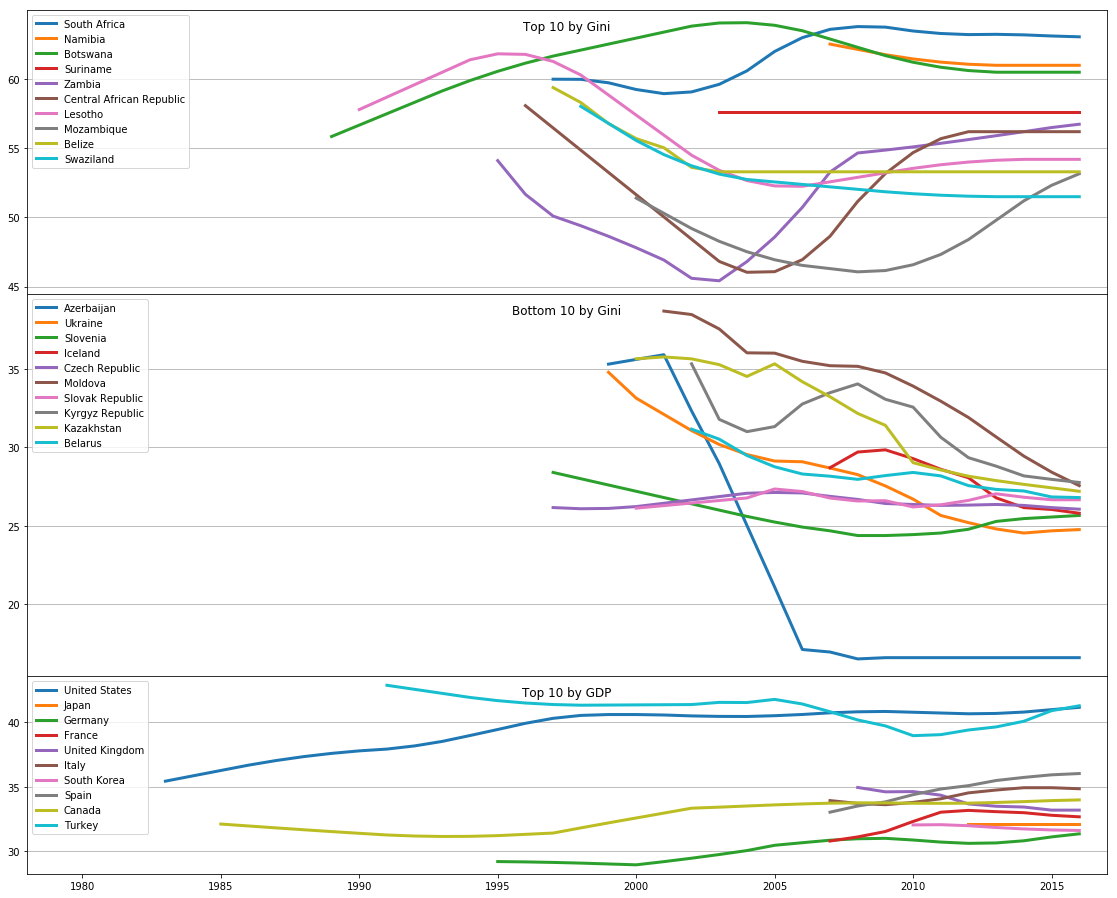

In [17]:
plot_graphs(df_gini_clean)

The graph shows a clear trend for all three groups. While most developed and rich countries already have considerably low indices, the index has been clearly growing for the past years. The bottom of the index "started" with low inequality and continues to decline. The top of the index has large deviations and spikes which can be potentially explained by lack of rigorous data, but the general trend seems to be that they have not change thier standing for the period of observations.

## GDP Comparison
Now let's see how top and bottom 10 countries by Gini stand on total GDP rating as of 2013 (which is the most recent available data).
We're going to build histograms of distributions of countries by quantiles of GDP rating.

In [18]:
df_gini_top_10_qs = pd.DataFrame(columns = ['country', 'quantile'])
df_gini_bottom_10_qs = pd.DataFrame(columns = ['country', 'quantile'])

In [19]:
for country_name in names_top_10_by_gini:
    for perc in [0.25, 0.5, 0.75, 1]:
        if df_total_gdp_clean['2013'].filter(pd.Series(country_name))[0] < \
        df_total_gdp_clean[['2013']].quantile(perc)[0]:
            df_gini_top_10_qs = df_gini_top_10_qs.append({
                'country': country_name,
                'quantile': int(perc / 0.25)
            }, ignore_index=True)
            break

In [20]:
for country_name in names_bottom_10_by_gini:
    for perc in [0.25, 0.5, 0.75, 1]:
        if df_total_gdp_clean['2013'].filter(pd.Series(country_name))[0] < \
        df_total_gdp_clean[['2013']].quantile(perc)[0]:
            df_gini_bottom_10_qs = df_gini_bottom_10_qs.append({
                'country': country_name,
                'quantile': int(perc / 0.25)
            }, ignore_index=True)
            break

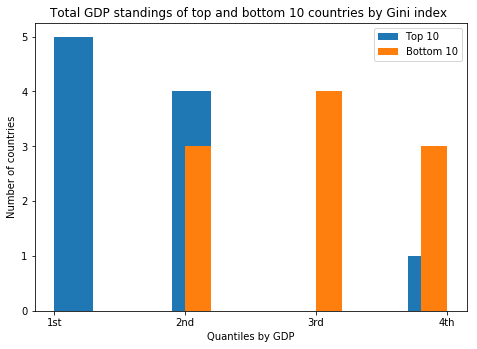

In [36]:
hist_fig = plt.figure(figsize=(6,4))
hist_axes = hist_fig.add_axes([0, 1, 1, 1],
                              title = 'Total GDP standings of top and bottom 10 countries by Gini index ',
                              xticks = [1, 2, 3, 4],
                              xticklabels = ['1st', '2nd', '3rd', '4th'],
                              xlabel = 'Quantiles by GDP',
                              ylabel = 'Number of countries')
hist_axes.hist(df_gini_top_10_qs[['quantile']].values)
hist_axes.hist(df_gini_bottom_10_qs[['quantile']].values)
hist_axes.legend(['Top 10', 'Bottom 10']);

We can clearly see that while the most of the top countries fall into 1st and 2nd quantile (and the distribution is
quite considerably skewed to the right), the countries from the bottom of the index are distributed almost evenly across 2nd, 3rd and 4th quantiles.

## Comparison To Service Industry Proportion Trends

Building the graphs for service industry proportions is roughly similar to Gini graphs.

In [ ]:
plot_graphs(df_serv_clean, ytick_size = 10)

The graphs show that the countries with lower Gini index are growing their service industries faster than countries with higher Gini index values. The top 10 developed countries by GDP the last 5 years see stagnating service industry growth. 

## Dynamics of Income Proportion of 10% Richest and 10% Poorest

In [ ]:
plot_graphs(df_richest_10_inc_clean)

In [ ]:
plot_graphs(df_poorest_10_inc_clean, ytick_size = 2)

Both of the graphs show clear and predictable trends. In the bottom 10 countries by Gini index income proportion of the poorest 10% increases alongside a decline of income proportion of the richest 10% which most likely explains steady decline in index values. In top 10 developed countries by GDP the trend is reversed. The top 10 countries by Gini index have their values seemingly steady.

## Conclusions and Observations

1. A trend of stagnation of service industry for countries with raising inequality index and falling income share of poorest 10%. It seems like poorest 10% contribution to economy has more effect on service industry than supposed contributions of the richest 10%.
2. A trend for countries with already high index values to preserve their status quo in regards to Gini index.
3. A general trend among rich developed countries for steady raise of inequality.
4. The countries at the top of Gini index are African countries and amongst the poorest countries. 

### Limitations

1. Data has a lot of gaps which have been either interpolated with existing values or forward filled for a better and easier plotting. Furthermore, the data has been transformed by rolling mean algorithm to smooth the graphs and emphasize the trends.
2. Given data is insufficient to draw any causal conclusions as global economic processes are extremely complex and a search for causes is out of scope of this project. However, the correlations observed are notable and suggest further analysis in search for common causes.

# Appendix

## Sources

* https://www.gapminder.org/data/
* https://www.cia.gov/library/publications/the-world-factbook/appendix/appendix-b.html
* https://docs.python.org
* https://matplotlib.org
* https://pandas.pydata.org